## Load data

In [1]:
import re
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.utils import np_utils
def extract_urls_from_data_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()

    urls = re.findall(r'GET (.*?) HTTP/1\.\d', data)

    return urls

train_data_file_path = '/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_normalTraffic_train.txt'
train_urls = extract_urls_from_data_file(train_data_file_path)
train_urls = train_urls + extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt')
train_label = [0]*len(extract_urls_from_data_file(train_data_file_path)) + [1]*len(extract_urls_from_data_file('/kaggle/input/dataset-csic2010/web-application-attacks-datasets-master/csic_2010/dataset_cisc_train_test/cisc_anomalousTraffic_test.txt'))
train_label = np.array(train_label)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Train model

In [2]:
import urllib.parse
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.utils import np_utils
from keras.utils import pad_sequences

def decode_and_split_http_request(http_request):
    decoded_request = urllib.parse.unquote(http_request)

    special_characters = ['/', '&', '+', '?', '=', '@', ':']
    split_request = []
    current_token = ''

    for char in decoded_request:
        if char in special_characters:
            if current_token:
                split_request.append(current_token)
                current_token = ''
        else:
            current_token += char

    if current_token:
        split_request.append(current_token)

    return split_request
import time
start_time = time.time()
preprocessed_requests = [decode_and_split_http_request(http_request) for http_request in train_urls]

preprocessed_requests, X_test, train_label, y_test = train_test_split(preprocessed_requests, train_label, test_size=0.2, random_state=42)

# Train Word2Vec model
model = Word2Vec(sentences=preprocessed_requests + X_test, sg=1, vector_size=100, window=5, min_count=1)
# Get word vectors
word_vectors = model.wv

# Create feature matrix
features = [[word_vectors[word] for word in request] for request in preprocessed_requests]
# Determine the maximum sequence length
max_sequence_length = max(len(request) for request in features)
# Pad sequences to have the same length
padded_features = pad_sequences(features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Convert target labels to categorical format
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(train_label)
target_one_hot = np_utils.to_categorical(target_encoded)

# Split data into training and testing sets
X_train, y_train = padded_features, target_one_hot

# Reshape X_train and X_test
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)

# Build Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=20, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
print("Thời gian chạy: ", time.time()-start_time)
# Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Loss: {loss}")
# print(f"Accuracy: {accuracy}")


Epoch 1/20
970/970 [==============================] - 670s 676ms/step - loss: 0.2907 - accuracy: 0.8510 - val_loss: 0.1598 - val_accuracy: 0.9167
Epoch 2/20
970/970 [==============================] - 649s 669ms/step - loss: 0.1413 - accuracy: 0.9396 - val_loss: 0.1095 - val_accuracy: 0.9527
Epoch 3/20
970/970 [==============================] - 655s 675ms/step - loss: 0.1072 - accuracy: 0.9559 - val_loss: 0.0920 - val_accuracy: 0.9649
Epoch 4/20
970/970 [==============================] - 659s 680ms/step - loss: 0.1004 - accuracy: 0.9605 - val_loss: 0.1063 - val_accuracy: 0.9597
Epoch 5/20
970/970 [==============================] - 649s 669ms/step - loss: 0.0981 - accuracy: 0.9618 - val_loss: 0.0983 - val_accuracy: 0.9661
Epoch 6/20
970/970 [==============================] - 654s 674ms/step - loss: 0.0941 - accuracy: 0.9638 - val_loss: 0.0840 - val_accuracy: 0.9675
Epoch 7/20
970/970 [==============================] - 668s 688ms/step - loss: 0.0878 - accuracy: 0.9675 - val_loss: 0.0907 -

In [3]:
import time

start_time = time.time()
# Create feature matrix
features = [[word_vectors[word] for word in request] for request in X_test]
# Determine the maximum sequence length
# max_sequence_length = max(len(request) for request in features)
# Pad sequences to have the same length
padded_features = pad_sequences(features, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Convert target labels to categorical format
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(y_test)
target_one_hot = np_utils.to_categorical(target_encoded)

# Split data into training and testing sets
X_test, y_test = padded_features, target_one_hot
y_prob = model.predict(X_test)
print("Thời gian chạy là: --- %s giây ---" % (time.time() - start_time))

270/270 [==============================] - 14s 49ms/step
Thời gian chạy là: --- 15.054502248764038 giây ---


## Visualize model

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 52, 80)           45120     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               16160     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 61,362
Trainable params: 61,362
Non-trainable params: 0
_________________________________________________________________


In [5]:
y_test = np.argmax(y_test, axis=1)

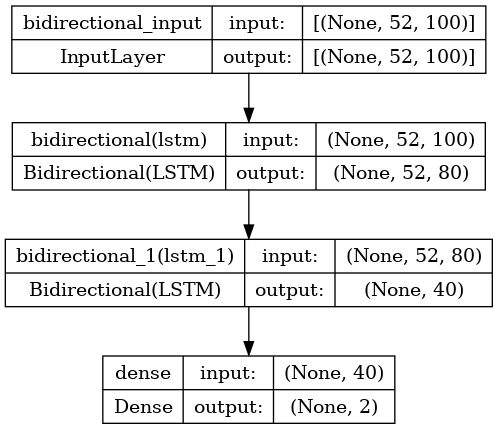

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Evaluate

In [7]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
import sklearn.metrics as metrics
import pandas as pd
clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

270/270 [==============================] - 13s 50ms/step
              precision    recall  f1-score   support

           0     0.9737    0.9941    0.9838      5627
           1     0.9885    0.9495    0.9686      2991

    accuracy                         0.9786      8618
   macro avg     0.9811    0.9718    0.9762      8618
weighted avg     0.9789    0.9786    0.9785      8618

[[5594   33]
 [ 151 2840]]
      TPR       FPR       FNR   ROC AUC
   0.9495    0.0059    0.0505    0.9951


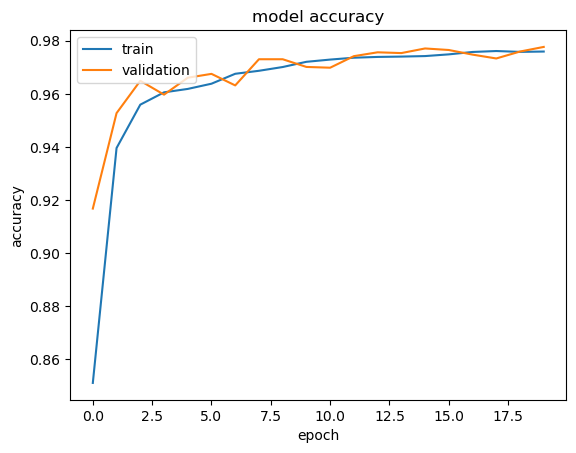

In [8]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

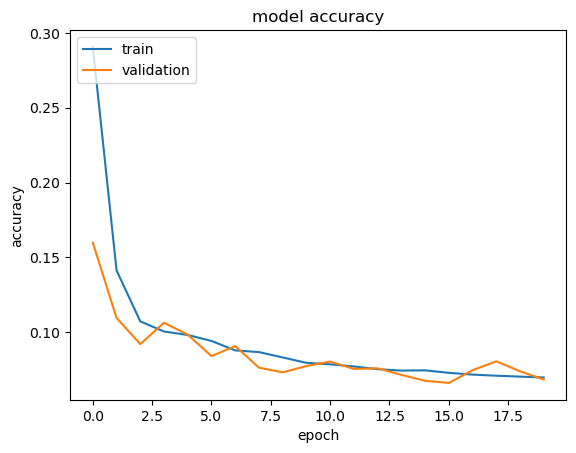

In [9]:
def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_loss(hist)